In [12]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

### Train a DNN on the modified dataset

In [13]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=6000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

Creating data...


FigureCanvasNbAgg()

Train Size: (5400, 2)
Test Size: (600,)
Categories: [array([0, 1])]


In [14]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [15]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, epochs=30, batch_size=20, verbose=0):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    y_train = hot_encoder.transform(y)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=verbose)
    
    return history, ZScaler


In [6]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, epochs=50, batch_size=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 14.4 s, sys: 4.35 s, total: 18.7 s
Wall time: 8.41 s


In [7]:
# Plotting results from history
# plot_history(history)

In [8]:
nn.evaluate(Zscaler.transform(X_test),hot_encoder.transform(y_test))

600/600 [==============================] - 0s 53us/step


[0.0011064505646936596, 1.0]

## Performing LRP

In [9]:
def perform_analysis(model, analyzer, data, labels=[]):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    df_anal = pd.DataFrame(analysis)
    
    return df_anal


scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
# lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)

all_lrp_E = perform_analysis(model,lrp_E, all_samples)

Prediction Accuracy
6000/6000 [==============================] - 0s 8us/step
Scores on data set: loss=0.001 accuracy=1.0000
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


NameError: name 'plot_args' is not defined

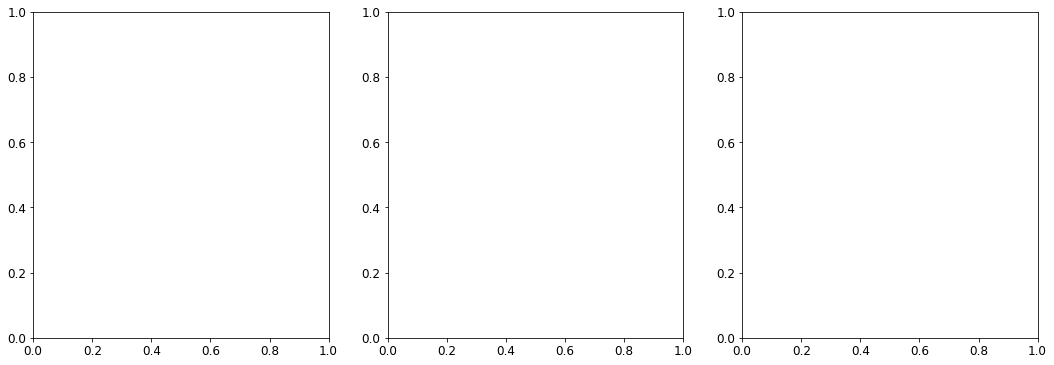

In [10]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

plot_args["c"] = "label"
original_data.plot(ax=axs[0], title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

# Peforming an analysis on depths

In [16]:
import innvestigate
import innvestigate.utils as iutils

plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": "Set1", "s":10, "alpha":0.25}

def runDNN(depth, epochs=50):
    nn = build_dnn(NUM_FEATURES)
    history, ZScaler = train_model(nn, X_train, y_train, 
                                   epochs=epochs, batch_size=20)
    
    
    scaled_samples = ZScaler.transform(X_valid)
    final_acc = nn.evaluate(scaled_samples,hot_encoder.transform(y_valid), verbose=0)

    # Getting all the samples that can be correctly predicted
    cp_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
    lrp_labels = y_valid_original[correct_idxs]


    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(cp_samples)
    
    return (final_acc, lrp_results, lrp_labels)

In [18]:
depth_epochs = [(2,50),(3,50)] #,(4,100),(5,100), (5,200), (6,100)]#SWITCH FROM DICTIONARY TO LIST PLS

plt.close("Depth Comparison")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="Depth Comparison")
# plt.tight_layout()

for i,(d, epochs) in enumerate(depth_epochs):
    
    final_acc, lrp_results, lrp_labels = runDNN(d, epochs)
    
    pos_lrp = lrp_results.copy()
    pos_lrp[pos_lrp<0] = 0
    data = pos_lrp

    axs[i].scatter(*data.T, s=50, linewidth=0, c=lrp_labels, alpha=0.5, cmap=plot_args["cmap"])
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, epochs))


FigureCanvasNbAgg()

Prediction Accuracy
6000/6000 [==============================] - 0s 9us/step
Scores on data set: loss=0.001 accuracy=1.0000
Prediction Accuracy
6000/6000 [==============================] - 0s 9us/step
Scores on data set: loss=0.001 accuracy=1.0000


# Depth Comparison with Cross Folds
> ### Only using Unique Depth,Epoch Pairs...

In [19]:
def getKF(X,y, n_splits=10):
    from sklearn.model_selection import StratifiedKFold as KFold
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 ) #Default = 10

    for train_index, test_index in kf.split(X,y):
        yield train_index, test_index

Creating data...


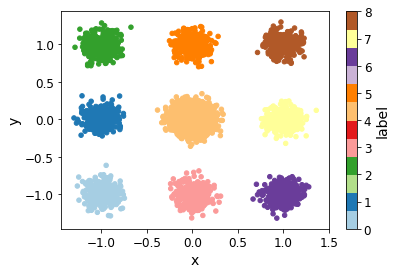

In [96]:
from time import time

depth_epochs = [(2,50),(3,50), (5,200)]
# depth_epochs = [(2,50),(3,50),(4,100),(5,100), (5,200), (6,100)]

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=3000)
X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(modded_samples, original_labels, training_labels)

hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)

def runDNN(depth, epochs, train_data, test_data):
    nn = build_dnn(NUM_FEATURES)
    X_train, y_train = train_data
    X_test, y_test = test_data

    history, ZScaler = train_model(nn, X_train, y_train, 
                                   epochs=epochs, batch_size=20)

    scaled_samples = ZScaler.transform(X_test)
    final_acc = nn.evaluate(scaled_samples,hot_encoder.transform(y_test), verbose=0)

    # Getting all the samples that can be correctly predicted
    all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_test, enc = hot_encoder)

    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(all_samples)

    return (final_acc, lrp_results, correct_idxs)

def runCV(depth,epoch):
    
    start_time = time()
    
    histories = []
    testing_indxs =[]
    predictions = []
    true_labels = []
    cv_original_labels = []
    cv_lrp_results = []
    zoo = []
    
    for i, (train_index, test_index) in enumerate(getKF(X, y_original)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test  = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_test_original = y_original.iloc[test_index]

        final_acc, lrp_results, lrp_idxs = runDNN(depth, epoch, train_data = [X_train,y_train], test_data = [X_test, y_test])

        cv_original_labels.extend(y_test_original[lrp_idxs])
        cv_lrp_results.extend(lrp_results)

        print("Fold {} scores: loss={:0.3f} accuracy={:.4f}".format(
            i, final_acc[0], final_acc[1]))

    print("{}/{} Runtime: {:.3f}s".format(depth, epoch, time()-start_time))

    return (cv_lrp_results, cv_original_labels)

Prediction Accuracy
302/302 [==============================] - 0s 16us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 0 scores: loss=0.002 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 10us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 1 scores: loss=0.002 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 15us/step
Scores on data set: loss=0.001 accuracy=1.0000
Fold 2 scores: loss=0.001 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 14us/step
Scores on data set: loss=0.001 accuracy=1.0000
Fold 3 scores: loss=0.001 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 12us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 4 scores: loss=0.002 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 12us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 5 scores: loss=0.002 accuracy=1.0000
Prediction

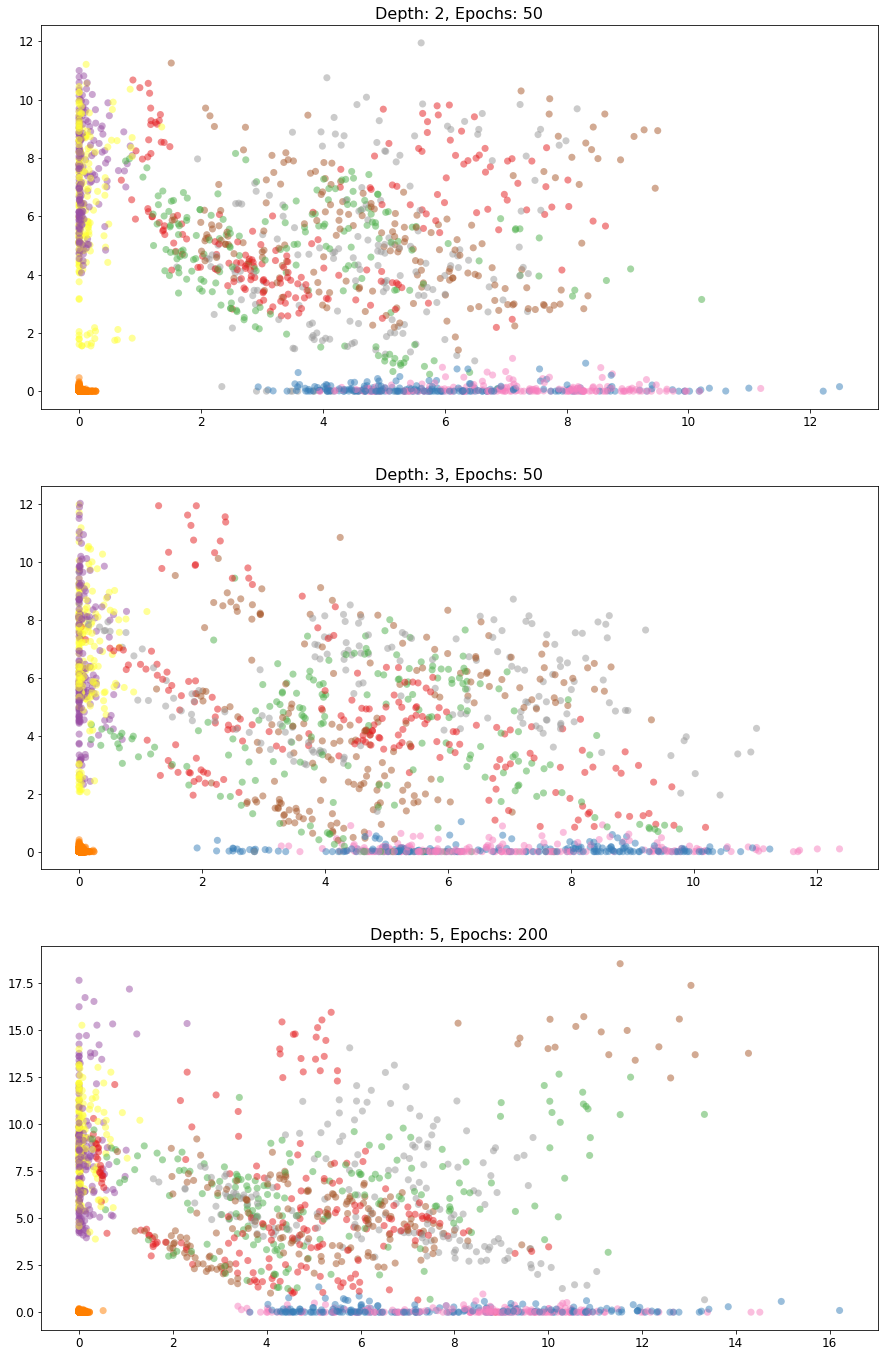

In [97]:
plt.close("CV Depth Comparison")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="CV Depth Comparison")
# plt.tight_layout()

runData = []
runLabels = []

for i,(d, epochs) in enumerate(depth_epochs):
    
    lrp_results, lrp_labels = runCV(d, epochs)
    
    pos_lrp = np.array(lrp_results)
    pos_lrp[pos_lrp<0] = 0
    data = pos_lrp
    runData.append(data)
    runLabels.append(lrp_labels)
    
#     noise = list(cluster_labels).count(-1)/len(cluster_labels)
#     hscore,cscore,vscore = metrics.homogeneity_completeness_v_measure(y_valid_original, cluster_labels)
#     sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
    
#     _metrics.append([num_clusters,noise,sil_score,hscore,cscore,vscore])
    
    
    axs[i].scatter(*data.T, s=50, linewidth=0, c=lrp_labels, alpha=0.5, cmap=plot_args["cmap"])
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, epochs))

## Generating Clusters  

In [165]:
import hdbscan
from sklearn import metrics
from s_dbw import S_Dbw
import seaborn as sns
%matplotlib widget
# sns.set_context('poster')
# sns.set_style('white')
plt.rcParams['axes.titlesize'] = 16
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [139]:
def clusterPerf(data, labels, cluster_sizes, plot=True):
    
    if plot:
        plt.close("Cluster Comparison")
        fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(16,10*(1+len(cluster_sizes))), num="Cluster Comparison")
        plt.title("Cluster Comparison")


        axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
        axs[0].set_title("Original Distribution")

    _metrics = []

    for i,size in enumerate(cluster_sizes):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

         ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

        color_palette = sns.color_palette("bright", num_clusters)
        cluster_colors = [color_palette[x] if x >= 0
                          else (0, 0, 0)
                          for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                                 zip(cluster_colors, clusterer.probabilities_)]

#         print(cluster_labels)
        
        noise = list(cluster_labels).count(-1)/len(cluster_labels)

        halkidi_s_Dbw = S_Dbw(data, cluster_labels, centers_id=None, method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        kim_s_Dbw = S_Dbw(data, cluster_labels, centers_id=None, method='Kim',
                    centr='mean', nearest_centr=True, metric='euclidean')
        tong_s_Dbw = S_Dbw(data, cluster_labels, centers_id=None, method='Tong',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
        
        _metrics.append([num_clusters,noise,sil_score, halkidi_s_Dbw, kim_s_Dbw, tong_s_Dbw])

        if plot:
            axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
            axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
            axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                        horizontalalignment='right', verticalalignment='top',
                        fontsize=14, transform=axs[i+1].transAxes)

    if plot: plt.show()

    scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette","Halkidi", "Kim", "Tong"], index=cluster_sizes)
    
    return scores

In [138]:
cluster_sizes = [15,25,35,50,65,100]
_metrics = []
# cluster_size = 50

for i,(depth, epochs) in enumerate(depth_epochs):
    data = runData[i]
    labels = runLabels[i]
    score = clusterPerf(data,labels,cluster_sizes, plot=False)
    _metrics.append(score)

[11 -1 11 ...  6  6 -1]
[ 4 -1  4 ...  1  1 -1]
[ 0  0  0 ...  2  2 -1]
[ 0  0  0 ...  2  2 -1]
[ 0  0  0 ...  1  1 -1]
[ 0  0  0 ...  2  2 -1]
[12  7 12 ... -1 16 -1]
[ 7  5  7 ...  3  3 -1]
[ 5  5  5 ...  2  2 -1]
[ 1  1  1 ...  2  2 -1]
[ 1  1  1 ... -1  3 -1]
[ 0  0  0 ... -1  3 -1]
[10 10 10 ...  0  0  0]
[4 4 4 ... 0 0 0]
[2 2 2 ... 0 0 0]
[1 1 1 ... 2 2 4]
[0 0 0 ... 2 2 4]
[0 0 0 ... 1 1 1]


In [153]:
# indexes = [[d for d,e in depth_epochs], cluster_sizes]
# indexes = pd.MultiIndex.from_product(indexes)
indexes = [d for d,e in depth_epochs]

scores = pd.concat(_metrics, keys=indexes)
scores

Clusters     Noise  Silhouette   Halkidi       Kim      Tong
2 15         13  0.192667    0.405126  0.708960  0.250620  0.345131
  25          7  0.300667    0.295745  0.479017  0.275334  0.312286
  35          5  0.165000    0.611958  0.519488  0.383878  0.458431
  50          5  0.180000    0.599283  0.491588  0.514421  0.519527
  65          3  0.080667    0.663958  0.717368  0.532770  0.849249
  100         3  0.137333    0.645545  0.697713  0.460454  0.641716
3 15         19  0.290667    0.223909  0.509081  0.130891  0.173517
  25          8  0.146333    0.430366  0.744849  0.303773  0.317149
  35          6  0.104333    0.493042  0.657602  0.365265  0.426926
  50          5  0.140333    0.496141  0.570267  0.399997  0.491620
  65          5  0.266000    0.362885  0.587762  0.487503  0.390560
  100         4  0.183667    0.613745  0.488574  0.360653  0.517483
5 15         11  0.075667    0.395559  2.205246  0.494122  1.933791
  25          6  0.113667    0.353615  1.906284  0.750840  3.045734
  35          3  0.099333    0.387164  1.255429  0.581469  0.875397
  50          5  0.232667    0.434356  0.635901  0.678909  0.605802
  65          5  0.213667    0.452350  0.608119  0.623846  0.540240
  100         2  0.042333    0.579830  0.818324  0.552381  0.995238

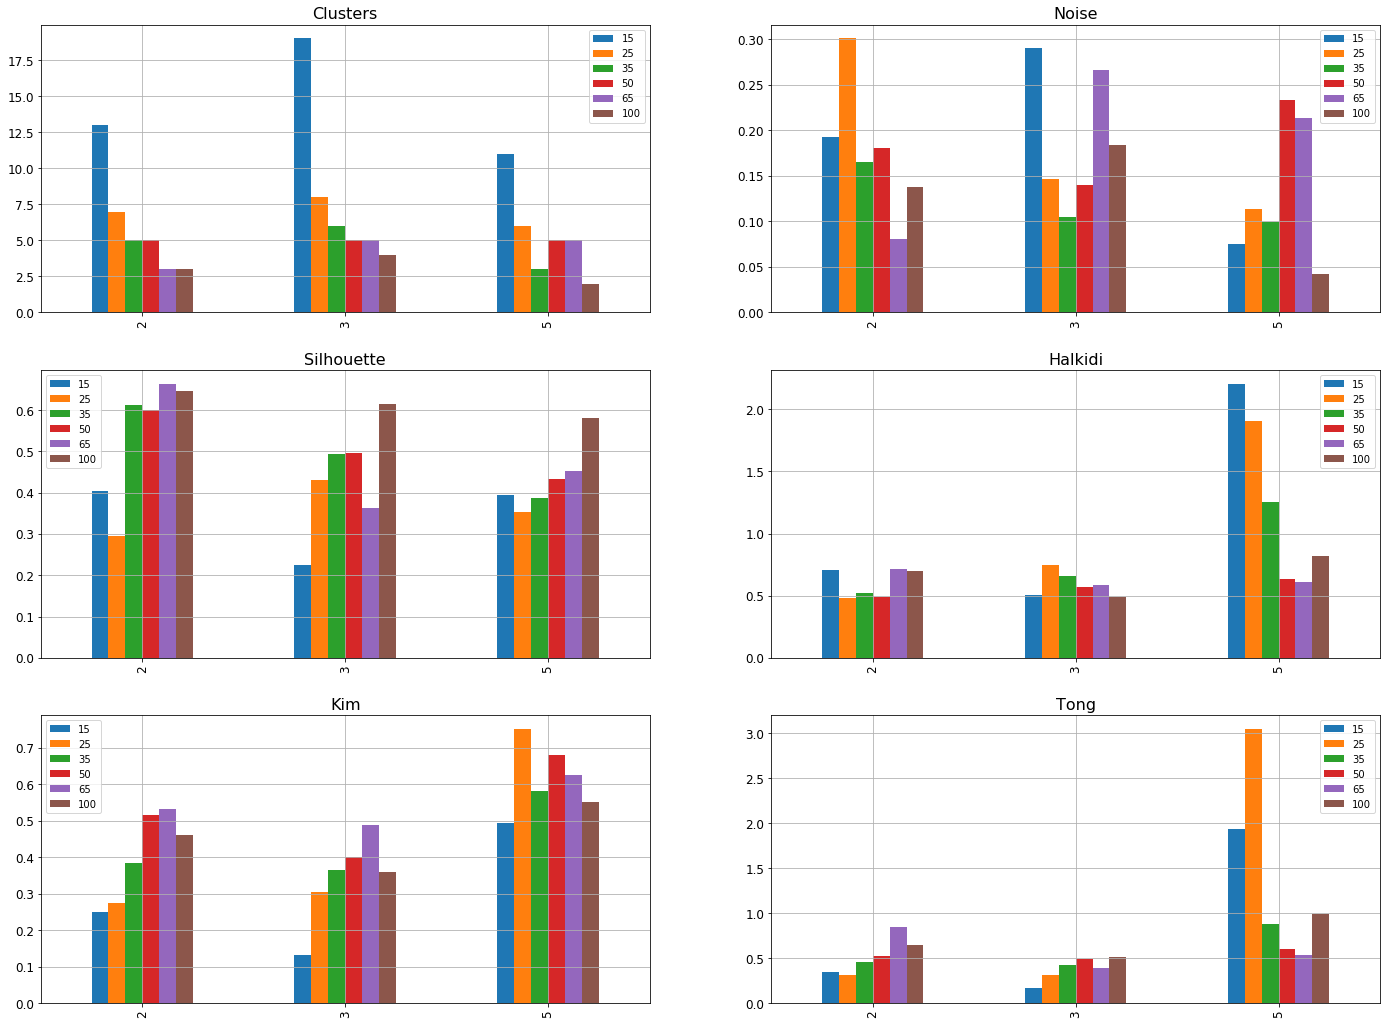

In [154]:
plt.close("Score Comparison")
fig, axs = plt.subplots(len(scores.columns)//2,2, figsize=(8*len(scores.columns)//2,18), num="Score Comparison")
axs = axs.flatten()

for i,metric_ in enumerate(scores.columns):
    scores[metric_].unstack().plot(ax=axs[i],kind="bar", grid=True)
    axs[i].set_title(metric_)

FigureCanvasNbAgg()

25
100
65


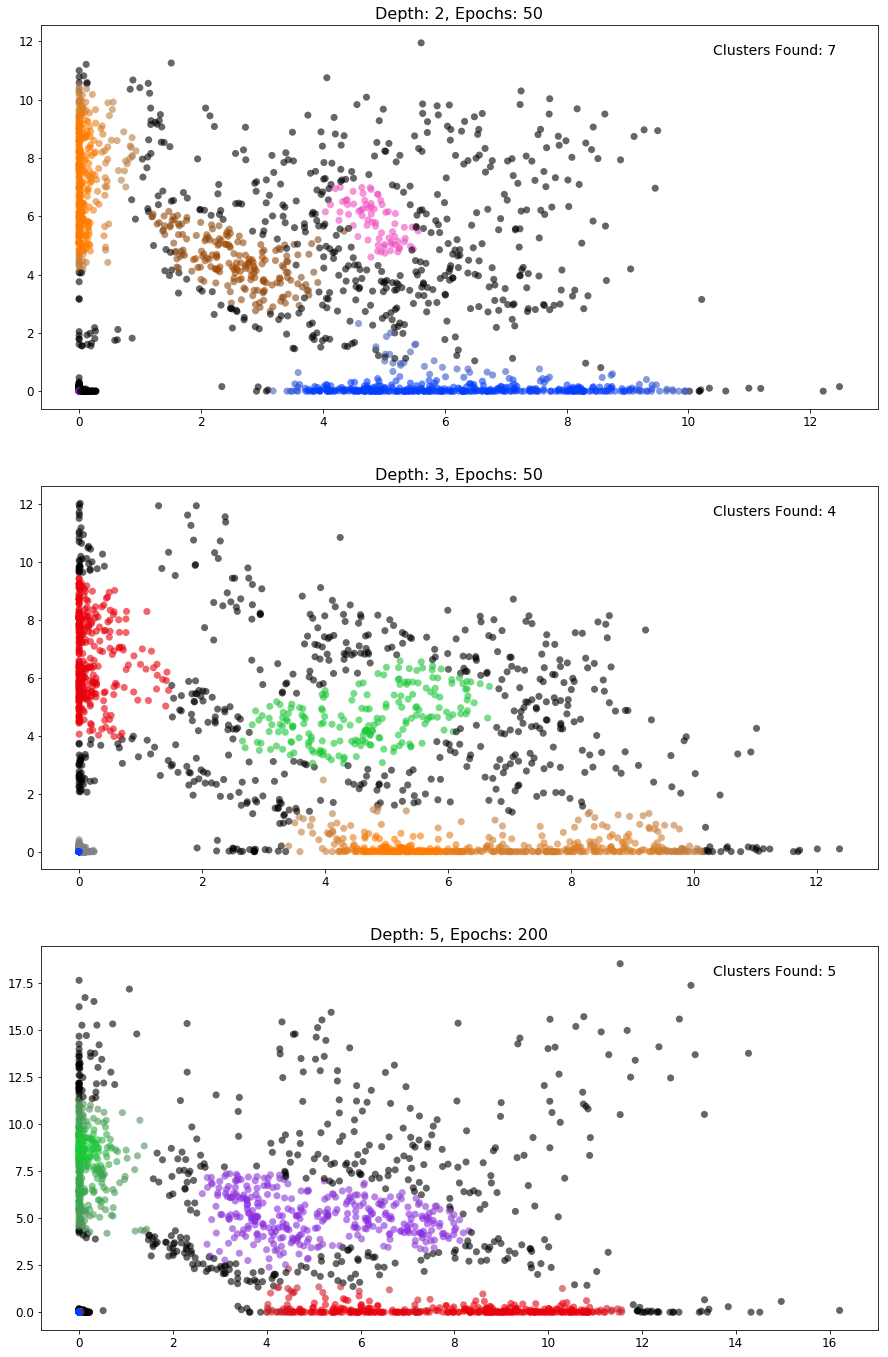

In [168]:
plt.close("Best Cluster")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="Best Cluster")

for i,(d,e) in enumerate(depth_epochs):
    
    best_size = int(scores.loc[d]["Halkidi"].idxmin())
    print(best_size)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=best_size)
    data = runData[i]
    y_valid_original = runLabels[i]
    
    clusterer.fit(data)
    cluster_labels = clusterer.labels_

    ## Number of clusters in labels, ignoring noise if present.
    num_clusters = cluster_labels.max() + 1

    color_palette = sns.color_palette("bright", num_clusters)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0, 0, 0)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]

    axs[i].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, e))
    axs[i].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                horizontalalignment='right', verticalalignment='top',
                fontsize=14, transform=axs[i].transAxes)

In [170]:
best_halkidi = scores["Halkidi"].idxmin()
best_halkidi

(2, 25)

FigureCanvasNbAgg()

,Clusters,Noise,Silhouette,Halkidi,Kim,Tong
15,13,0.192667,0.405126,0.708960,0.250620,0.345131
25,7,0.300667,0.295745,0.479017,0.275334,0.312286
35,5,0.165000,0.611958,0.519488,0.383878,0.458431
50,5,0.180000,0.599283,0.491588,0.514421,0.519527
65,3,0.080667,0.663958,0.717368,0.532770,0.849249
100,3,0.137333,0.645545,0.697713,0.460454,0.641716


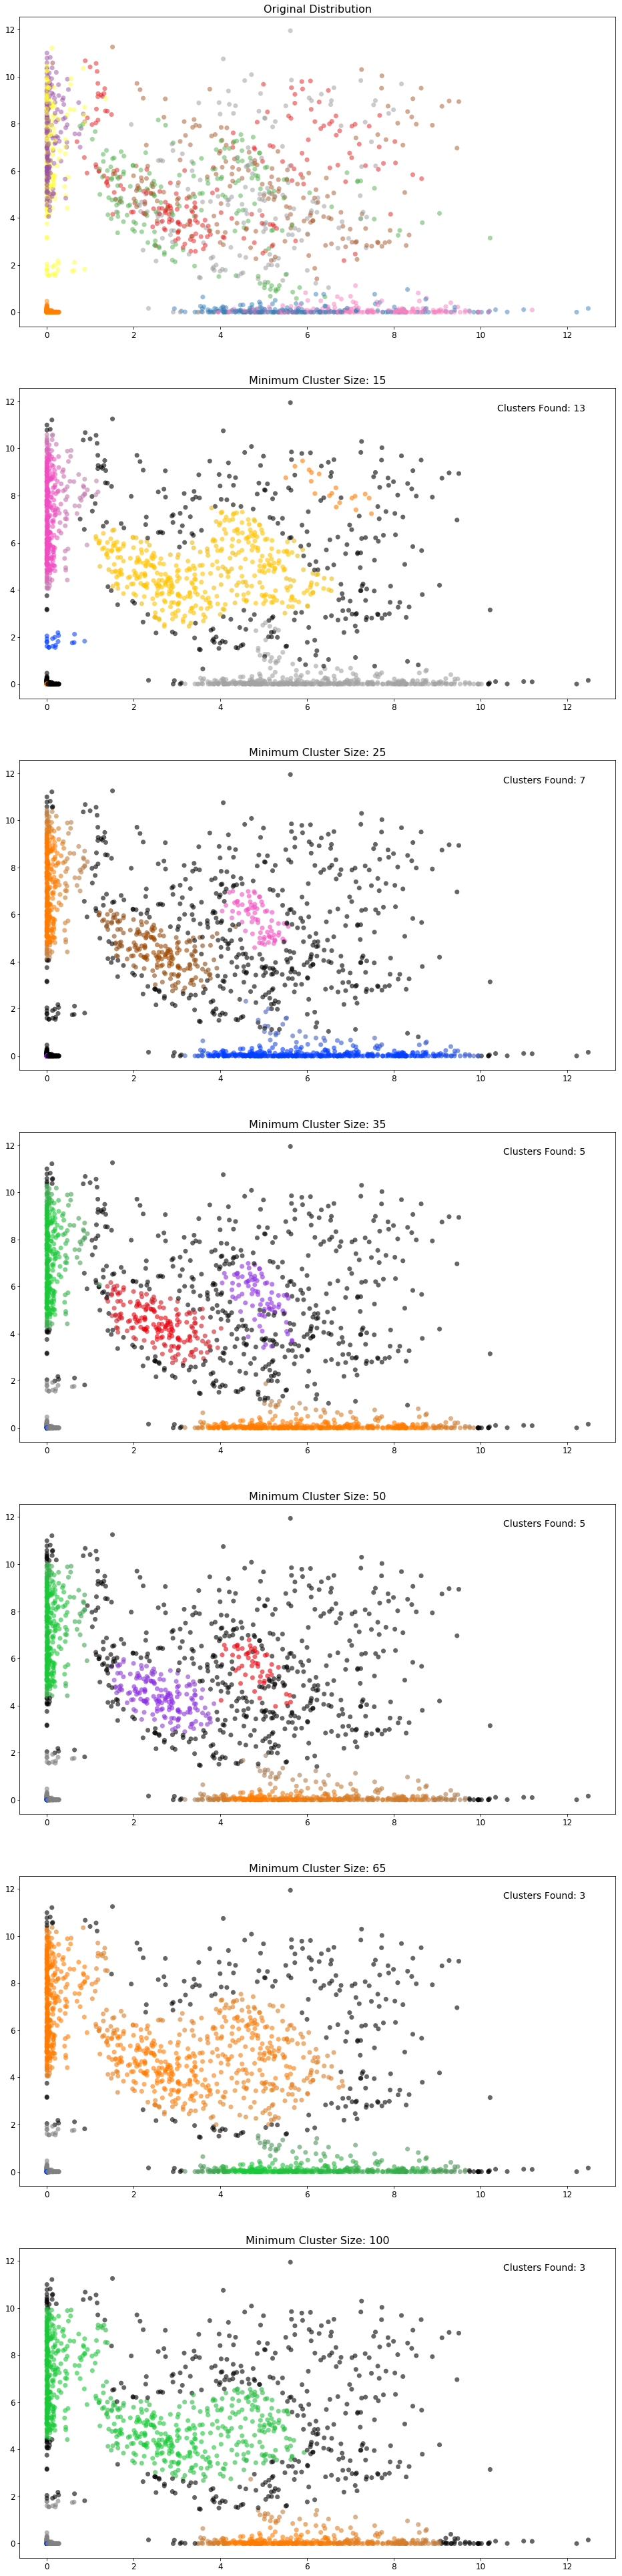

In [171]:
clusterPerf(runData[0], runLabels[0], cluster_sizes)